<a href="https://colab.research.google.com/github/ptl-harsh/Image_Super_resolution_4x/blob/main/Image_Super_resolution_4x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Notebook: 4× Image Super-Resolution with EDSR

```markdown
# Image Super-Resolution (4×)
Enhance low-resolution images by generating high-resolution versions with a 4× upscaling factor using an EDSR model.
```  

In [2]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Cell 2: Unzip Dataset
!unzip -q /content/drive/MyDrive/Datasets/image_super_resolution_dataset.zip -d /content/data

In [4]:
# Cell 3: Imports
import os, glob, numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim

In [5]:
# Cell 4: Dataset Definition
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, patch_size=48, augment=True):
        self.lr_paths = sorted(glob.glob(os.path.join(lr_dir, '*.png')))
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, '*.png')))
        self.patch_size = patch_size
        self.augment = augment
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.lr_paths)

    def __getitem__(self, idx):
        lr = Image.open(self.lr_paths[idx]).convert('RGB')
        hr = Image.open(self.hr_paths[idx]).convert('RGB')

        if self.augment:
            i, j, h, w = transforms.RandomCrop.get_params(
                hr, output_size=(self.patch_size * 4, self.patch_size * 4)
            )
            hr = transforms.functional.crop(hr, i, j, h, w)
            lr = transforms.functional.resize(hr, (self.patch_size, self.patch_size), Image.BICUBIC)
        else:
            hr = transforms.CenterCrop((self.patch_size * 4, self.patch_size * 4))(hr)
            lr = transforms.Resize((self.patch_size, self.patch_size), Image.BICUBIC)(hr)

        lr_tensor = self.to_tensor(lr)
        hr_tensor = self.to_tensor(hr)
        return lr_tensor, hr_tensor

In [6]:
# Cell 5: Model Definition (EDSR)
class ResidualBlock(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.conv1 = nn.Conv2d(num_features, num_features, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(num_features, num_features, 3, padding=1)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        return self.conv2(out) + x

class EDSR(nn.Module):
    def __init__(self, scale_factor=4, num_blocks=16, num_features=64):
        super().__init__()
        self.entry = nn.Conv2d(3, num_features, 3, padding=1)
        self.res_blocks = nn.Sequential(*[ResidualBlock(num_features) for _ in range(num_blocks)])
        self.mid_conv = nn.Conv2d(num_features, num_features, 3, padding=1)

        upsampler = []
        for _ in range(int(np.log2(scale_factor))):
            upsampler += [
                nn.Conv2d(num_features, num_features * 4, 3, padding=1),
                nn.PixelShuffle(2),
                nn.ReLU(inplace=True)
            ]
        self.upsampler = nn.Sequential(*upsampler)
        self.exit = nn.Conv2d(num_features, 3, 3, padding=1)

    def forward(self, x):
        x = self.entry(x)
        res = x
        x = self.res_blocks(x)
        x = self.mid_conv(x) + res
        x = self.upsampler(x)
        return self.exit(x)

In [7]:
# Cell 6: Hyperparameters & Paths
train_lr = '/content/data/image_super_resolution_dataset/scaling_4x/train/LR'
train_hr = '/content/data/image_super_resolution_dataset/scaling_4x/train/HR'
test_lr  = '/content/data/image_super_resolution_dataset/scaling_4x/test/LR'
test_hr  = '/content/data/image_super_resolution_dataset/scaling_4x/test/HR'

batch_size  = 16
lr_rate     = 1e-4
num_epochs  = 200
device      = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Cell 7: Data Loaders
train_ds    = SRDataset(train_lr, train_hr, patch_size=48, augment=True)
train_loader= DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds     = SRDataset(test_lr, test_hr, patch_size=48, augment=False)

In [9]:
# Cell 8: Initialize Model, Loss, Optimizer
model     = EDSR(scale_factor=4).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

In [10]:
# Cell 9: Training Loop
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    for lr_imgs, hr_imgs in tqdm(train_loader, desc=f"Epoch {epoch}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        sr_imgs = model(lr_imgs)
        loss = criterion(sr_imgs, hr_imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)
    print(f"Epoch {epoch} | Loss: {avg_loss:.4f}")
    if epoch % 50 == 0:
        torch.save(model.state_dict(), f"edsr_epoch{epoch}.pth")

Epoch 1: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Epoch 1 | Loss: 0.3480


Epoch 2: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 2 | Loss: 0.1816


Epoch 3: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch 3 | Loss: 0.1368


Epoch 4: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch 4 | Loss: 0.1243


Epoch 5: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch 5 | Loss: 0.1161


Epoch 6: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch 6 | Loss: 0.1095


Epoch 7: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch 7 | Loss: 0.1036


Epoch 8: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch 8 | Loss: 0.1003


Epoch 9: 100%|██████████| 5/5 [00:00<00:00,  5.95it/s]


Epoch 9 | Loss: 0.0975


Epoch 10: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch 10 | Loss: 0.0936


Epoch 11: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch 11 | Loss: 0.0896


Epoch 12: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch 12 | Loss: 0.0819


Epoch 13: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


Epoch 13 | Loss: 0.0798


Epoch 14: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 14 | Loss: 0.0793


Epoch 15: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


Epoch 15 | Loss: 0.0749


Epoch 16: 100%|██████████| 5/5 [00:01<00:00,  4.78it/s]


Epoch 16 | Loss: 0.0752


Epoch 17: 100%|██████████| 5/5 [00:00<00:00,  5.89it/s]


Epoch 17 | Loss: 0.0723


Epoch 18: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch 18 | Loss: 0.0695


Epoch 19: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch 19 | Loss: 0.0699


Epoch 20: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch 20 | Loss: 0.0713


Epoch 21: 100%|██████████| 5/5 [00:00<00:00,  5.91it/s]


Epoch 21 | Loss: 0.0705


Epoch 22: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch 22 | Loss: 0.0677


Epoch 23: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch 23 | Loss: 0.0691


Epoch 24: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch 24 | Loss: 0.0636


Epoch 25: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch 25 | Loss: 0.0660


Epoch 26: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch 26 | Loss: 0.0641


Epoch 27: 100%|██████████| 5/5 [00:00<00:00,  5.44it/s]


Epoch 27 | Loss: 0.0647


Epoch 28: 100%|██████████| 5/5 [00:01<00:00,  4.27it/s]


Epoch 28 | Loss: 0.0624


Epoch 29: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


Epoch 29 | Loss: 0.0674


Epoch 30: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 30 | Loss: 0.0663


Epoch 31: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch 31 | Loss: 0.0654


Epoch 32: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch 32 | Loss: 0.0635


Epoch 33: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch 33 | Loss: 0.0633


Epoch 34: 100%|██████████| 5/5 [00:00<00:00,  5.86it/s]


Epoch 34 | Loss: 0.0625


Epoch 35: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch 35 | Loss: 0.0619


Epoch 36: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch 36 | Loss: 0.0579


Epoch 37: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch 37 | Loss: 0.0590


Epoch 38: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch 38 | Loss: 0.0571


Epoch 39: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch 39 | Loss: 0.0566


Epoch 40: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 40 | Loss: 0.0570


Epoch 41: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch 41 | Loss: 0.0573


Epoch 42: 100%|██████████| 5/5 [00:01<00:00,  4.99it/s]


Epoch 42 | Loss: 0.0570


Epoch 43: 100%|██████████| 5/5 [00:01<00:00,  4.06it/s]


Epoch 43 | Loss: 0.0568


Epoch 44: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 44 | Loss: 0.0556


Epoch 45: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]


Epoch 45 | Loss: 0.0559


Epoch 46: 100%|██████████| 5/5 [00:00<00:00,  5.90it/s]


Epoch 46 | Loss: 0.0554


Epoch 47: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch 47 | Loss: 0.0558


Epoch 48: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch 48 | Loss: 0.0547


Epoch 49: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch 49 | Loss: 0.0544


Epoch 50: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 50 | Loss: 0.0556


Epoch 51: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch 51 | Loss: 0.0551


Epoch 52: 100%|██████████| 5/5 [00:00<00:00,  5.57it/s]


Epoch 52 | Loss: 0.0539


Epoch 53: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch 53 | Loss: 0.0560


Epoch 54: 100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


Epoch 54 | Loss: 0.0549


Epoch 55: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch 55 | Loss: 0.0558


Epoch 56: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch 56 | Loss: 0.0536


Epoch 57: 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]


Epoch 57 | Loss: 0.0526


Epoch 58: 100%|██████████| 5/5 [00:01<00:00,  3.87it/s]


Epoch 58 | Loss: 0.0516


Epoch 59: 100%|██████████| 5/5 [00:01<00:00,  4.38it/s]


Epoch 59 | Loss: 0.0521


Epoch 60: 100%|██████████| 5/5 [00:00<00:00,  5.00it/s]


Epoch 60 | Loss: 0.0517


Epoch 61: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch 61 | Loss: 0.0505


Epoch 62: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch 62 | Loss: 0.0525


Epoch 63: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch 63 | Loss: 0.0513


Epoch 64: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch 64 | Loss: 0.0483


Epoch 65: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 65 | Loss: 0.0504


Epoch 66: 100%|██████████| 5/5 [00:01<00:00,  3.44it/s]


Epoch 66 | Loss: 0.0515


Epoch 67: 100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Epoch 67 | Loss: 0.0521


Epoch 68: 100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


Epoch 68 | Loss: 0.0501


Epoch 69: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


Epoch 69 | Loss: 0.0491


Epoch 70: 100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Epoch 70 | Loss: 0.0497


Epoch 71: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Epoch 71 | Loss: 0.0487


Epoch 72: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch 72 | Loss: 0.0469


Epoch 73: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch 73 | Loss: 0.0507


Epoch 74: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch 74 | Loss: 0.0495


Epoch 75: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch 75 | Loss: 0.0493


Epoch 76: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch 76 | Loss: 0.0483


Epoch 77: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch 77 | Loss: 0.0499


Epoch 78: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 78 | Loss: 0.0466


Epoch 79: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch 79 | Loss: 0.0503


Epoch 80: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch 80 | Loss: 0.0483


Epoch 81: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 81 | Loss: 0.0474


Epoch 82: 100%|██████████| 5/5 [00:00<00:00,  5.62it/s]


Epoch 82 | Loss: 0.0498


Epoch 83: 100%|██████████| 5/5 [00:01<00:00,  4.07it/s]


Epoch 83 | Loss: 0.0498


Epoch 84: 100%|██████████| 5/5 [00:01<00:00,  4.02it/s]


Epoch 84 | Loss: 0.0496


Epoch 85: 100%|██████████| 5/5 [00:01<00:00,  4.57it/s]


Epoch 85 | Loss: 0.0490


Epoch 86: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch 86 | Loss: 0.0508


Epoch 87: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch 87 | Loss: 0.0489


Epoch 88: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 88 | Loss: 0.0480


Epoch 89: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch 89 | Loss: 0.0488


Epoch 90: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch 90 | Loss: 0.0479


Epoch 91: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch 91 | Loss: 0.0472


Epoch 92: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch 92 | Loss: 0.0471


Epoch 93: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch 93 | Loss: 0.0476


Epoch 94: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 94 | Loss: 0.0465


Epoch 95: 100%|██████████| 5/5 [00:00<00:00,  5.51it/s]


Epoch 95 | Loss: 0.0474


Epoch 96: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch 96 | Loss: 0.0471


Epoch 97: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 97 | Loss: 0.0473


Epoch 98: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 98 | Loss: 0.0460


Epoch 99: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 99 | Loss: 0.0456


Epoch 100: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]


Epoch 100 | Loss: 0.0460


Epoch 101: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch 101 | Loss: 0.0466


Epoch 102: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch 102 | Loss: 0.0454


Epoch 103: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch 103 | Loss: 0.0472


Epoch 104: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch 104 | Loss: 0.0470


Epoch 105: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch 105 | Loss: 0.0462


Epoch 106: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch 106 | Loss: 0.0460


Epoch 107: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch 107 | Loss: 0.0464


Epoch 108: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch 108 | Loss: 0.0464


Epoch 109: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch 109 | Loss: 0.0453


Epoch 110: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch 110 | Loss: 0.0471


Epoch 111: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch 111 | Loss: 0.0464


Epoch 112: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 112 | Loss: 0.0472


Epoch 113: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Epoch 113 | Loss: 0.0450


Epoch 114: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


Epoch 114 | Loss: 0.0456


Epoch 115: 100%|██████████| 5/5 [00:00<00:00,  5.29it/s]


Epoch 115 | Loss: 0.0459


Epoch 116: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 116 | Loss: 0.0471


Epoch 117: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch 117 | Loss: 0.0456


Epoch 118: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]


Epoch 118 | Loss: 0.0469


Epoch 119: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch 119 | Loss: 0.0460


Epoch 120: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch 120 | Loss: 0.0460


Epoch 121: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch 121 | Loss: 0.0457


Epoch 122: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch 122 | Loss: 0.0468


Epoch 123: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch 123 | Loss: 0.0460


Epoch 124: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch 124 | Loss: 0.0458


Epoch 125: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch 125 | Loss: 0.0461


Epoch 126: 100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Epoch 126 | Loss: 0.0463


Epoch 127: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s]


Epoch 127 | Loss: 0.0457


Epoch 128: 100%|██████████| 5/5 [00:01<00:00,  4.13it/s]


Epoch 128 | Loss: 0.0455


Epoch 129: 100%|██████████| 5/5 [00:01<00:00,  4.35it/s]


Epoch 129 | Loss: 0.0465


Epoch 130: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch 130 | Loss: 0.0464


Epoch 131: 100%|██████████| 5/5 [00:00<00:00,  5.72it/s]


Epoch 131 | Loss: 0.0461


Epoch 132: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch 132 | Loss: 0.0448


Epoch 133: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch 133 | Loss: 0.0451


Epoch 134: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch 134 | Loss: 0.0468


Epoch 135: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch 135 | Loss: 0.0459


Epoch 136: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


Epoch 136 | Loss: 0.0464


Epoch 137: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch 137 | Loss: 0.0452


Epoch 138: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch 138 | Loss: 0.0455


Epoch 139: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch 139 | Loss: 0.0467


Epoch 140: 100%|██████████| 5/5 [00:00<00:00,  5.85it/s]


Epoch 140 | Loss: 0.0452


Epoch 141: 100%|██████████| 5/5 [00:01<00:00,  5.00it/s]


Epoch 141 | Loss: 0.0476


Epoch 142: 100%|██████████| 5/5 [00:01<00:00,  3.82it/s]


Epoch 142 | Loss: 0.0455


Epoch 143: 100%|██████████| 5/5 [00:01<00:00,  4.43it/s]


Epoch 143 | Loss: 0.0464


Epoch 144: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]


Epoch 144 | Loss: 0.0466


Epoch 145: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch 145 | Loss: 0.0447


Epoch 146: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch 146 | Loss: 0.0461


Epoch 147: 100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Epoch 147 | Loss: 0.0455


Epoch 148: 100%|██████████| 5/5 [00:00<00:00,  5.21it/s]


Epoch 148 | Loss: 0.0468


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch 149 | Loss: 0.0451


Epoch 150: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch 150 | Loss: 0.0448


Epoch 151: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s]


Epoch 151 | Loss: 0.0442


Epoch 152: 100%|██████████| 5/5 [00:00<00:00,  5.77it/s]


Epoch 152 | Loss: 0.0471


Epoch 153: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch 153 | Loss: 0.0456


Epoch 154: 100%|██████████| 5/5 [00:00<00:00,  5.84it/s]


Epoch 154 | Loss: 0.0467


Epoch 155: 100%|██████████| 5/5 [00:00<00:00,  5.43it/s]


Epoch 155 | Loss: 0.0450


Epoch 156: 100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


Epoch 156 | Loss: 0.0437


Epoch 157: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 157 | Loss: 0.0459


Epoch 158: 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]


Epoch 158 | Loss: 0.0442


Epoch 159: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch 159 | Loss: 0.0441


Epoch 160: 100%|██████████| 5/5 [00:00<00:00,  5.78it/s]


Epoch 160 | Loss: 0.0451


Epoch 161: 100%|██████████| 5/5 [00:00<00:00,  5.79it/s]


Epoch 161 | Loss: 0.0443


Epoch 162: 100%|██████████| 5/5 [00:00<00:00,  5.67it/s]


Epoch 162 | Loss: 0.0459


Epoch 163: 100%|██████████| 5/5 [00:00<00:00,  5.58it/s]


Epoch 163 | Loss: 0.0466


Epoch 164: 100%|██████████| 5/5 [00:00<00:00,  5.60it/s]


Epoch 164 | Loss: 0.0465


Epoch 165: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch 165 | Loss: 0.0440


Epoch 166: 100%|██████████| 5/5 [00:00<00:00,  5.83it/s]


Epoch 166 | Loss: 0.0464


Epoch 167: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch 167 | Loss: 0.0453


Epoch 168: 100%|██████████| 5/5 [00:00<00:00,  5.55it/s]


Epoch 168 | Loss: 0.0452


Epoch 169: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch 169 | Loss: 0.0442


Epoch 170: 100%|██████████| 5/5 [00:01<00:00,  4.37it/s]


Epoch 170 | Loss: 0.0470


Epoch 171: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


Epoch 171 | Loss: 0.0456


Epoch 172: 100%|██████████| 5/5 [00:01<00:00,  4.20it/s]


Epoch 172 | Loss: 0.0452


Epoch 173: 100%|██████████| 5/5 [00:01<00:00,  4.90it/s]


Epoch 173 | Loss: 0.0442


Epoch 174: 100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


Epoch 174 | Loss: 0.0452


Epoch 175: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch 175 | Loss: 0.0464


Epoch 176: 100%|██████████| 5/5 [00:00<00:00,  5.75it/s]


Epoch 176 | Loss: 0.0471


Epoch 177: 100%|██████████| 5/5 [00:00<00:00,  5.81it/s]


Epoch 177 | Loss: 0.0464


Epoch 178: 100%|██████████| 5/5 [00:00<00:00,  5.73it/s]


Epoch 178 | Loss: 0.0458


Epoch 179: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch 179 | Loss: 0.0450


Epoch 180: 100%|██████████| 5/5 [00:00<00:00,  5.59it/s]


Epoch 180 | Loss: 0.0446


Epoch 181: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch 181 | Loss: 0.0462


Epoch 182: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


Epoch 182 | Loss: 0.0434


Epoch 183: 100%|██████████| 5/5 [00:00<00:00,  5.82it/s]


Epoch 183 | Loss: 0.0459


Epoch 184: 100%|██████████| 5/5 [00:00<00:00,  5.50it/s]


Epoch 184 | Loss: 0.0452


Epoch 185: 100%|██████████| 5/5 [00:01<00:00,  4.33it/s]


Epoch 185 | Loss: 0.0444


Epoch 186: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Epoch 186 | Loss: 0.0463


Epoch 187: 100%|██████████| 5/5 [00:01<00:00,  4.45it/s]


Epoch 187 | Loss: 0.0465


Epoch 188: 100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


Epoch 188 | Loss: 0.0444


Epoch 189: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch 189 | Loss: 0.0463


Epoch 190: 100%|██████████| 5/5 [00:00<00:00,  5.61it/s]


Epoch 190 | Loss: 0.0452


Epoch 191: 100%|██████████| 5/5 [00:00<00:00,  5.74it/s]


Epoch 191 | Loss: 0.0460


Epoch 192: 100%|██████████| 5/5 [00:00<00:00,  5.49it/s]


Epoch 192 | Loss: 0.0457


Epoch 193: 100%|██████████| 5/5 [00:00<00:00,  5.63it/s]


Epoch 193 | Loss: 0.0459


Epoch 194: 100%|██████████| 5/5 [00:00<00:00,  5.69it/s]


Epoch 194 | Loss: 0.0464


Epoch 195: 100%|██████████| 5/5 [00:00<00:00,  5.66it/s]


Epoch 195 | Loss: 0.0461


Epoch 196: 100%|██████████| 5/5 [00:00<00:00,  5.70it/s]


Epoch 196 | Loss: 0.0450


Epoch 197: 100%|██████████| 5/5 [00:00<00:00,  5.71it/s]


Epoch 197 | Loss: 0.0464


Epoch 198: 100%|██████████| 5/5 [00:00<00:00,  5.80it/s]


Epoch 198 | Loss: 0.0464


Epoch 199: 100%|██████████| 5/5 [00:01<00:00,  4.77it/s]


Epoch 199 | Loss: 0.0458


Epoch 200: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Epoch 200 | Loss: 0.0457


In [12]:
# Cell 10: Evaluation (fixed to ensure matching dimensions and SSIM window)
model.eval()
psnr_vals, ssim_vals = [], []

with torch.no_grad():
    for lr_path, hr_path in zip(
            sorted(glob.glob(test_lr + '/*.png')),
            sorted(glob.glob(test_hr + '/*.png'))):

        # Load LR and HR images
        lr = Image.open(lr_path).convert('RGB')
        hr = Image.open(hr_path).convert('RGB')

        # Prepare LR tensor and move to device
        lr_t = transforms.ToTensor()(lr).unsqueeze(0).to(device)  # (1, C, H_lr, W_lr)

        # Generate SR output
        sr_tensor = model(lr_t).clamp(0, 1).cpu().squeeze(0)      # (C, H_sr, W_sr)

        # Load HR as tensor and resize to match SR spatial dimensions
        hr_tensor = transforms.ToTensor()(hr).unsqueeze(0)        # (1, C, H_hr, W_hr)
        hr_tensor = torch.nn.functional.interpolate(
            hr_tensor,
            size=sr_tensor.shape[1:],    # (H_sr, W_sr)
            mode='bicubic',
            align_corners=False
        ).squeeze(0)                    # (C, H_sr, W_sr)

        # Convert both to H×W×C NumPy arrays
        sr_np = sr_tensor.permute(1, 2, 0).numpy()
        hr_np = hr_tensor.permute(1, 2, 0).numpy()

        # Compute PSNR and SSIM (specify channel_axis for SSIM)
        psnr_vals.append(compute_psnr(hr_np, sr_np, data_range=1.0))
        ssim_vals.append(compute_ssim(hr_np, sr_np, data_range=1.0, channel_axis=2))

# Print average metrics
print(f"Avg PSNR: {np.mean(psnr_vals):.2f} dB")
print(f"Avg SSIM: {np.mean(ssim_vals):.4f}")

Avg PSNR: 25.92 dB
Avg SSIM: 0.6720


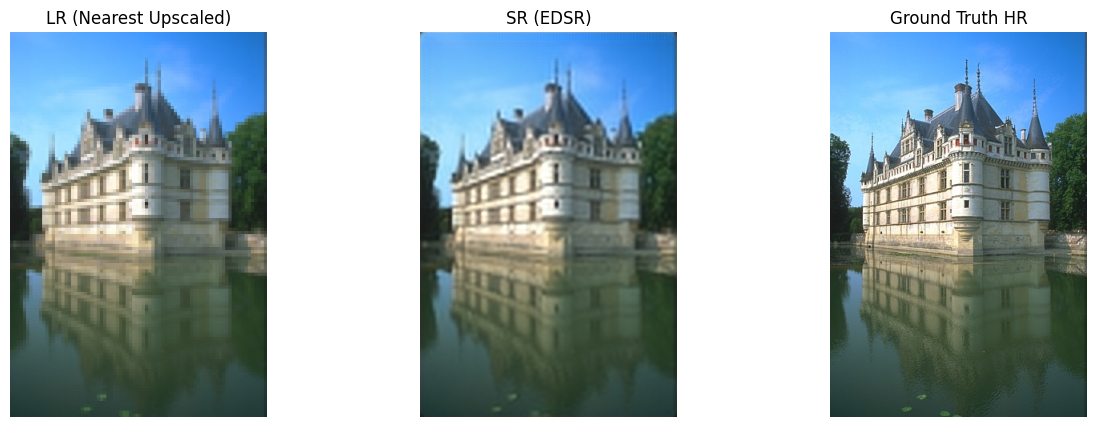

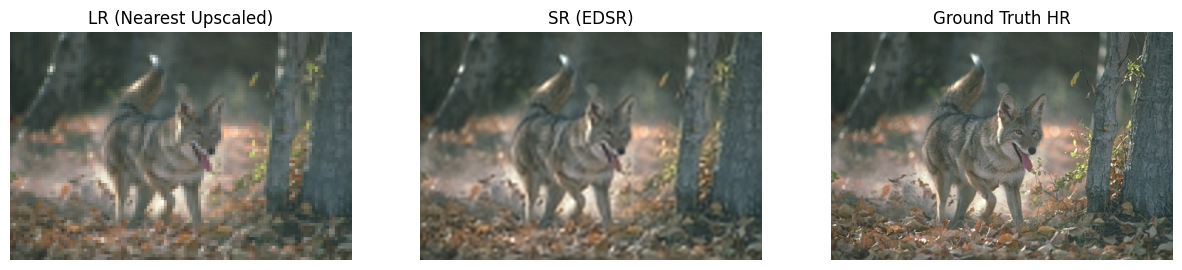

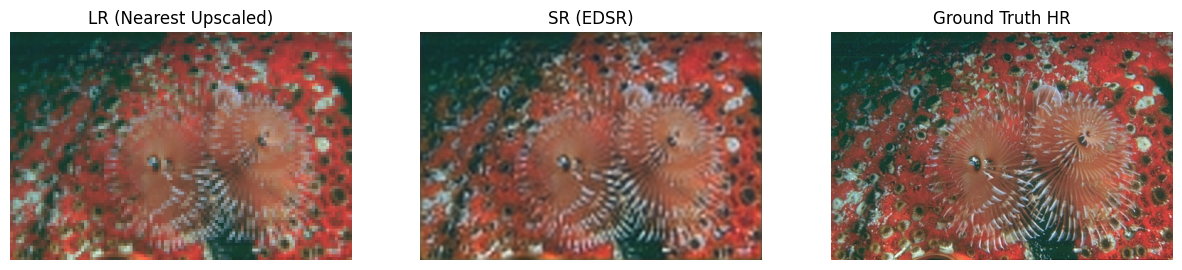

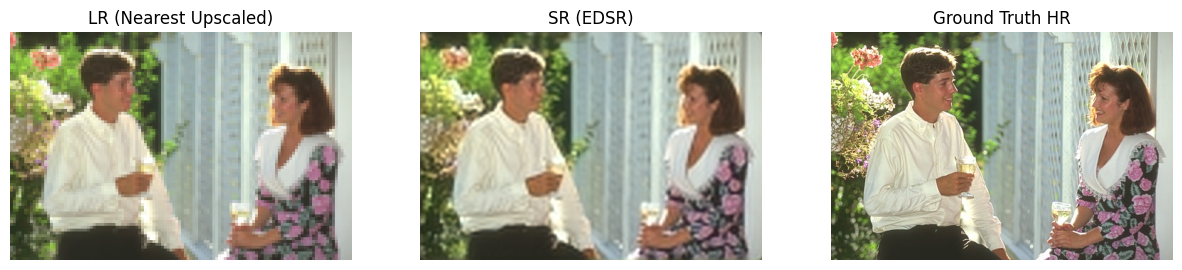

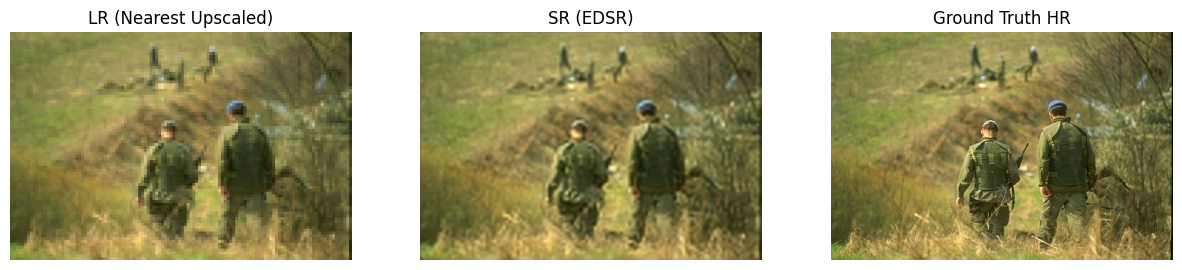

In [14]:
# Cell 11: Visualization

import torch
def show_images(idx=0):
    # Load LR and HR images
    lr = Image.open(sorted(glob.glob(test_lr + '/*.png'))[idx]).convert('RGB')
    hr = Image.open(sorted(glob.glob(test_hr + '/*.png'))[idx]).convert('RGB')

    # Generate SR image (detach gradients)
    lr_t = transforms.ToTensor()(lr).unsqueeze(0).to(device)
    with torch.no_grad():
        sr_tensor = model(lr_t).clamp(0,1).detach().cpu().squeeze(0)
    sr_img = sr_tensor.permute(1,2,0).numpy()

    # Plot side-by-side
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    ax[0].imshow(lr.resize((lr.width*4, lr.height*4), Image.NEAREST))
    ax[0].set_title('LR (Nearest Upscaled)')
    ax[1].imshow(sr_img)
    ax[1].set_title('SR (EDSR)')
    ax[2].imshow(hr)
    ax[2].set_title('Ground Truth HR')
    for a in ax:
        a.axis('off')
    plt.show()

# Show first 5 test samples
for i in range(min(5, len(sorted(glob.glob(test_lr + '/*.png'))))):
    show_images(i)

In [19]:
# Cell: Batch SR Inference & Saving High-Resolution Outputs

import os, glob
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F

# 1) Create output directories
output_dir    = "/content/sr_results"
bicubic_dir   = os.path.join(output_dir, "upsampled")      # nearest + bicubic
edsr_dir      = os.path.join(output_dir, "edsr_output")
os.makedirs(bicubic_dir, exist_ok=True)
os.makedirs(edsr_dir, exist_ok=True)

# 2) Ensure model is in eval mode
model.eval()

# 3) Process all LR images
for lr_path in sorted(glob.glob(test_lr + "/*.png")):
    fname = os.path.basename(lr_path)
    lr_img = Image.open(lr_path).convert("RGB")

    # a) 4× nearest-neighbor upsample
    nn_up = lr_img.resize((lr_img.width*4, lr_img.height*4), Image.NEAREST)
    nn_up.save(os.path.join(bicubic_dir, f"nn_{fname}"))

    # b) 4× bicubic upsample
    bic_up = lr_img.resize((lr_img.width*4, lr_img.height*4), Image.BICUBIC)
    bic_up.save(os.path.join(bicubic_dir, f"bicubic_{fname}"))

    # c) 4× EDSR super-resolution
    lr_t = transforms.ToTensor()(lr_img).unsqueeze(0).to(device)
    with torch.no_grad():
        sr_t = model(lr_t).clamp(0,1)
    # Convert tensor to PIL image
    sr_img = transforms.ToPILImage()(sr_t.cpu().squeeze(0))
    sr_img.save(os.path.join(edsr_dir, f"edsr_{fname}"))

print("Saved 4× upscaled images to:")
print("  - Nearest/Bicubic: ", bicubic_dir)
print("  - EDSR outputs:    ", edsr_dir)


Saved 4× upscaled images to:
  - Nearest/Bicubic:  /content/sr_results/upsampled
  - EDSR outputs:     /content/sr_results/edsr_output


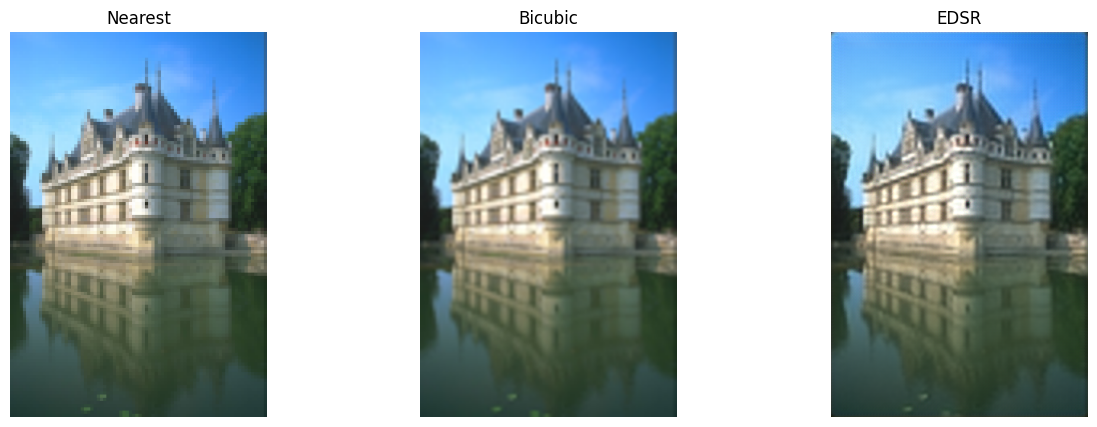

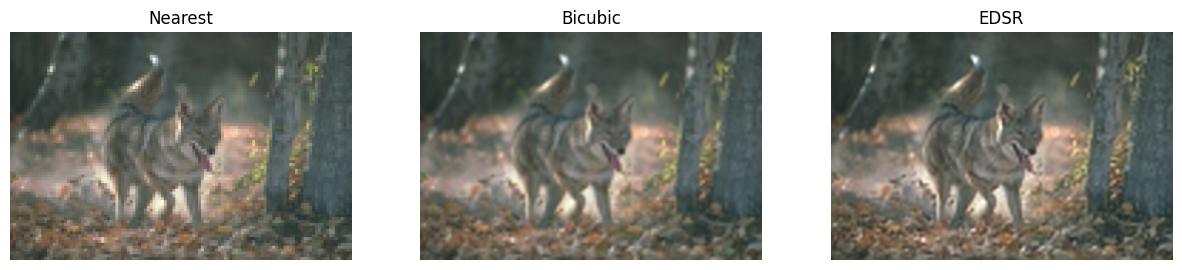

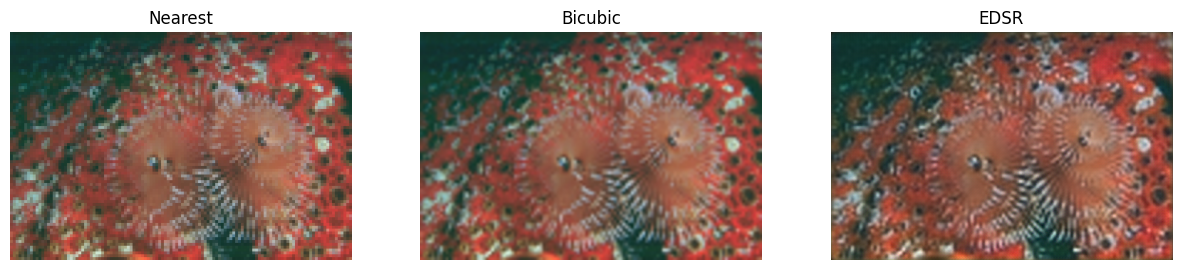

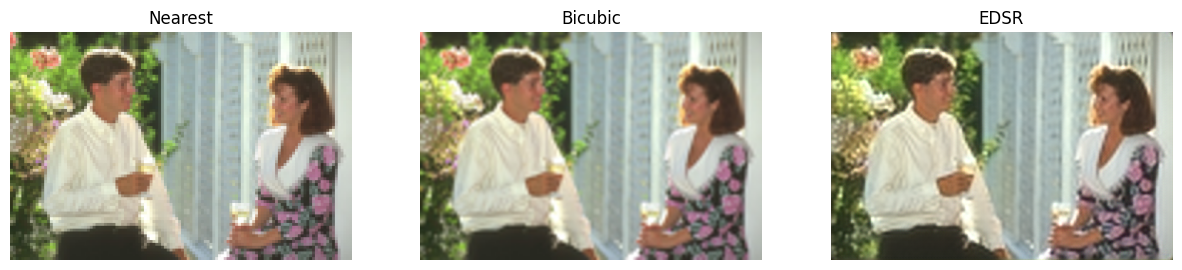

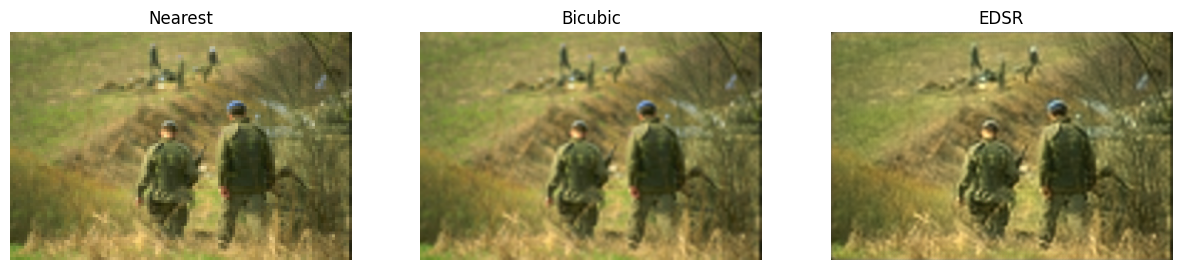

In [21]:
# Cell 12: Visualize & Compare All Saved Outputs
import os, glob
from PIL import Image
import matplotlib.pyplot as plt

# Paths from saved outputs
bicubic_dir = "/content/sr_results/upsampled"
edsr_dir    = "/content/sr_results/edsr_output"

# List EDSR-generated filenames
edsr_files = sorted([f for f in os.listdir(edsr_dir) if f.startswith('edsr_')])[:5]

for fname in edsr_files:
    original_name = fname.replace('edsr_', '')
    nn_path      = os.path.join(bicubic_dir, f"nn_{original_name}")
    bic_path     = os.path.join(bicubic_dir, f"bicubic_{original_name}")
    esdr_path    = os.path.join(edsr_dir, fname)

    # Load images
    nn_img   = Image.open(nn_path).convert('RGB')
    bic_img  = Image.open(bic_path).convert('RGB')
    esdr_img = Image.open(esdr_path).convert('RGB')

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(nn_img);  ax[0].set_title('Nearest')
    ax[1].imshow(bic_img); ax[1].set_title('Bicubic')
    ax[2].imshow(esdr_img); ax[2].set_title('EDSR')
    for a in ax:
        a.axis('off')
    plt.show()